<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN2_Q2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q2 Part C ECE528 LA2 - Isa Fontana

## Imports & SEED

In [1]:
import os, time, itertools, random, numpy as np, pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

SEED = 0
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# TensorBoard logging root
stamp = time.strftime("%Y%m%d-%H%M%S")
logdir_root = f"logs_q2c/{stamp}"
os.makedirs(logdir_root, exist_ok=True)

print("TF:", tf.__version__, "| Keras:", keras.__version__)

TF: 2.19.0 | Keras: 3.10.0


## Load, Split, Normalize (per usual duh)

In [2]:
# Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# train/val split (50k/10k)
val_size = 10000
x_val, y_val = x_train[-val_size:], y_train[-val_size:]
x_train, y_train = x_train[:-val_size], y_train[:-val_size]

# to float, scale, add channel dim
x_train = (x_train.astype("float32")/255.0)[..., None]
x_val   = (x_val.astype("float32")/255.0)[..., None]
x_test  = (x_test.astype("float32")/255.0)[..., None]

x_train.shape, x_val.shape, x_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((50000, 28, 28, 1), (10000, 28, 28, 1), (10000, 28, 28, 1))

## Defin HP Spaces

In [3]:
# HParams: choosing 2 layers to vary & 3 values each
HP_CONV1_FILTERS = hp.HParam("conv1_filters", hp.Discrete([32, 48, 64]))
HP_DENSE_UNITS   = hp.HParam("dense_units",   hp.Discrete([64, 128, 256]))

METRIC_ACC = "test_accuracy"

with tf.summary.create_file_writer(os.path.join(logdir_root, "hparams")).as_default():
    hp.hparams_config(
        hparams=[HP_CONV1_FILTERS, HP_DENSE_UNITS],
        metrics=[hp.Metric(METRIC_ACC, display_name="Test Accuracy")],
    )

## Model Builder

In [4]:
def build_q2c_model(conv1_filters=32, dense_units=128):
    gelu = layers.Activation(keras.activations.gelu)  # works across TF/Keras versions

    inputs = keras.Input((28,28,1))
    x = layers.Conv2D(conv1_filters, 3, padding="same")(inputs)
    x = gelu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = gelu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = gelu(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.30)(x)
    x = layers.Dense(dense_units)(x)
    x = gelu(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="q2c_gelu_gelu")
    # Use the same optimizer you favored in Q2(a/b); adamw did well for me
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Trial Run

In [5]:
def run_trial(conv1_filters, dense_units, run_id):
    logdir = os.path.join(logdir_root, f"conv{conv1_filters}_dense{dense_units}_{run_id}")

    model = build_q2c_model(conv1_filters, dense_units)

    # LR scheduling (matches my earlier setup)
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5,
                                          patience=2, min_lr=1e-5, verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5,
                                      restore_best_weights=True, verbose=0),
        keras.callbacks.TensorBoard(log_dir=logdir),
        hp.KerasCallback(logdir, {HP_CONV1_FILTERS: conv1_filters,
                                  HP_DENSE_UNITS: dense_units}),
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=12, batch_size=128, verbose=2,
        callbacks=callbacks
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    with tf.summary.create_file_writer(logdir).as_default():
        tf.summary.scalar(METRIC_ACC, test_acc, step=0)

    return model, float(test_acc), logdir

## Grid Search

In [6]:
results = []
best = {"acc": -1, "model": None, "cfg": None, "logdir": None}

run_id = 0
for f in HP_CONV1_FILTERS.domain.values:
    for u in HP_DENSE_UNITS.domain.values:
        run_id += 1
        print(f"=== Trial {run_id}: conv1_filters={f}, dense_units={u} ===")
        model, acc, logdir = run_trial(f, u, run_id)
        results.append({"conv1_filters": f, "dense_units": u, "test_acc": acc, "logdir": logdir, "model": model})
        if acc > best["acc"]:
            best = {"acc": acc, "model": model, "cfg": {"conv1_filters": f, "dense_units": u}, "logdir": logdir}

df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
df

=== Trial 1: conv1_filters=32, dense_units=64 ===
Epoch 1/12
391/391 - 14s - 36ms/step - accuracy: 0.7696 - loss: 0.6288 - val_accuracy: 0.8522 - val_loss: 0.4038 - learning_rate: 1.0000e-03
Epoch 2/12
391/391 - 1s - 4ms/step - accuracy: 0.8645 - loss: 0.3710 - val_accuracy: 0.8802 - val_loss: 0.3239 - learning_rate: 1.0000e-03
Epoch 3/12
391/391 - 1s - 4ms/step - accuracy: 0.8822 - loss: 0.3192 - val_accuracy: 0.8872 - val_loss: 0.3037 - learning_rate: 1.0000e-03
Epoch 4/12
391/391 - 2s - 4ms/step - accuracy: 0.8934 - loss: 0.2878 - val_accuracy: 0.8937 - val_loss: 0.2822 - learning_rate: 1.0000e-03
Epoch 5/12
391/391 - 1s - 4ms/step - accuracy: 0.9027 - loss: 0.2650 - val_accuracy: 0.9012 - val_loss: 0.2665 - learning_rate: 1.0000e-03
Epoch 6/12
391/391 - 1s - 4ms/step - accuracy: 0.9077 - loss: 0.2462 - val_accuracy: 0.9074 - val_loss: 0.2530 - learning_rate: 1.0000e-03
Epoch 7/12
391/391 - 1s - 4ms/step - accuracy: 0.9149 - loss: 0.2279 - val_accuracy: 0.9065 - val_loss: 0.2556 - l

,conv1_filters,dense_units,test_acc,logdir,model
0,48,64,0.9208,logs_q2c/20250924-025539/conv48_dense64_4,"<Functional name=q2c_gelu_gelu, built=True>"
1,64,256,0.9170,logs_q2c/20250924-025539/conv64_dense256_9,"<Functional name=q2c_gelu_gelu, built=True>"
2,64,128,0.9146,logs_q2c/20250924-025539/conv64_dense128_8,"<Functional name=q2c_gelu_gelu, built=True>"
3,32,64,0.9126,logs_q2c/20250924-025539/conv32_dense64_1,"<Functional name=q2c_gelu_gelu, built=True>"
4,48,256,0.9109,logs_q2c/20250924-025539/conv48_dense256_6,"<Functional name=q2c_gelu_gelu, built=True>"
5,32,128,0.9104,logs_q2c/20250924-025539/conv32_dense128_2,"<Functional name=q2c_gelu_gelu, built=True>"
6,48,128,0.9093,logs_q2c/20250924-025539/conv48_dense128_5,"<Functional name=q2c_gelu_gelu, built=True>"
7,64,64,0.9083,logs_q2c/20250924-025539/conv64_dense64_7,"<Functional name=q2c_gelu_gelu, built=True>"
8,32,256,0.9059,logs_q2c/20250924-025539/conv32_dense256_3,"<Functional name=q2c_gelu_gelu, built=True>"


## Plots

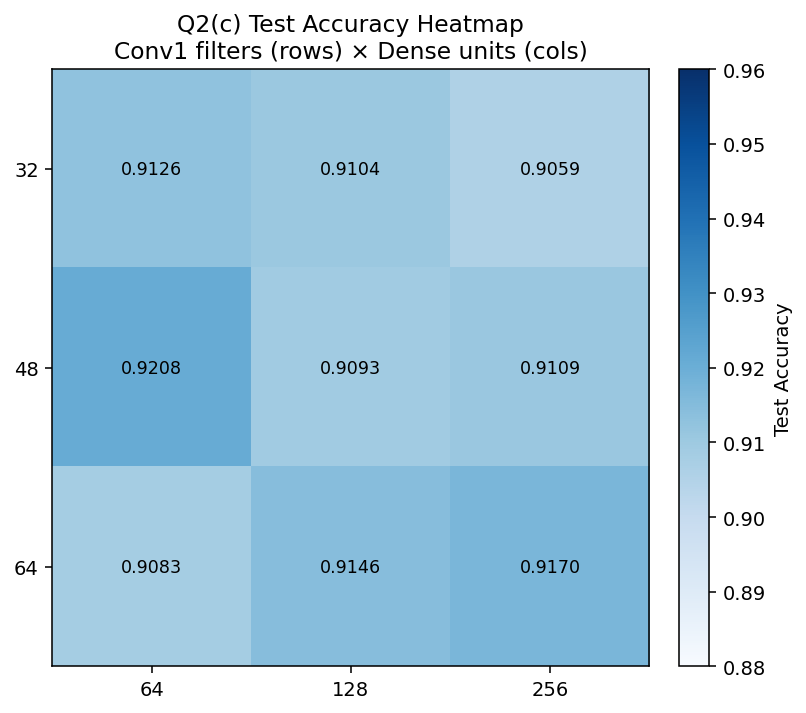

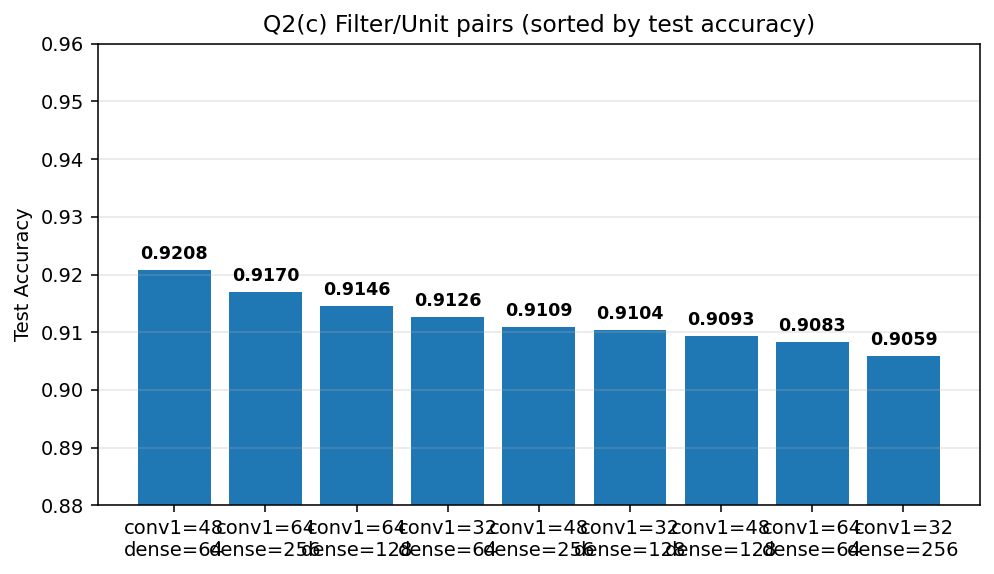

BEST: conv1_filters=48, dense_units=64, Test Acc=0.9208


In [7]:
os.makedirs("figs_q2c", exist_ok=True)

# Heatmap: rows = conv1 filters, cols = dense units
rows = sorted(HP_CONV1_FILTERS.domain.values)
cols = sorted(HP_DENSE_UNITS.domain.values)

mat = np.zeros((len(rows), len(cols)))
for i, r in enumerate(rows):
    for j, c in enumerate(cols):
        mat[i, j] = df[(df["conv1_filters"]==r) & (df["dense_units"]==c)]["test_acc"].values[0]

plt.figure(figsize=(6.2,5.2), dpi=140)
im = plt.imshow(mat, cmap="Blues", vmin=0.88, vmax=0.96)
plt.xticks(range(len(cols)), cols); plt.yticks(range(len(rows)), rows)
plt.title("Q2(c) Test Accuracy Heatmap\nConv1 filters (rows) × Dense units (cols)")
for i in range(len(rows)):
    for j in range(len(cols)):
        plt.text(j, i, f"{mat[i,j]:.4f}", ha="center", va="center", fontsize=9)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Test Accuracy")
plt.tight_layout()
plt.savefig("figs_q2c/q2c_heatmap.png"); plt.show()

# Sorted bar chart
plt.figure(figsize=(7.2,4.2), dpi=140)
labels = [f"conv1={r['conv1_filters']}\ndense={r['dense_units']}" for _, r in df.iterrows()]
vals = df["test_acc"].values
bars = plt.bar(range(len(vals)), vals)
plt.ylim(0.88, 0.96); plt.ylabel("Test Accuracy")
plt.title("Q2(c) Filter/Unit pairs (sorted by test accuracy)")
plt.xticks(range(len(vals)), labels)
for i, v in enumerate(vals):
    plt.text(i, v+0.0012, f"{v:.4f}", ha="center", va="bottom", fontsize=9, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("figs_q2c/q2c_bar_sorted.png"); plt.show()

# Save raw results
df.to_csv("figs_q2c/q2c_results.csv", index=False)

# Winner line
print(f"BEST: conv1_filters={best['cfg']['conv1_filters']}, "
      f"dense_units={best['cfg']['dense_units']}, Test Acc={best['acc']:.4f}")

## Best Model Layer (YAY)

,name,type,output_shape,activation,units/filters,kernel_size,pool_size,rate
0,input_layer_3,InputLayer,None,None,NaN,None,None,NaN
1,conv2d_9,Conv2D,None,linear,48.0,"(3, 3)",None,NaN
2,activation_3,Activation,None,gelu,NaN,None,None,NaN
3,max_pooling2d_9,MaxPooling2D,None,None,NaN,None,"(2, 2)",NaN
4,conv2d_10,Conv2D,None,linear,64.0,"(3, 3)",None,NaN
5,max_pooling2d_10,MaxPooling2D,None,None,NaN,None,"(2, 2)",NaN
6,conv2d_11,Conv2D,None,linear,128.0,"(3, 3)",None,NaN
7,max_pooling2d_11,MaxPooling2D,None,None,NaN,None,"(2, 2)",NaN
8,flatten_3,Flatten,None,None,NaN,None,None,NaN
9,dropout_3,Dropout,None,None,NaN,None,None,0.3


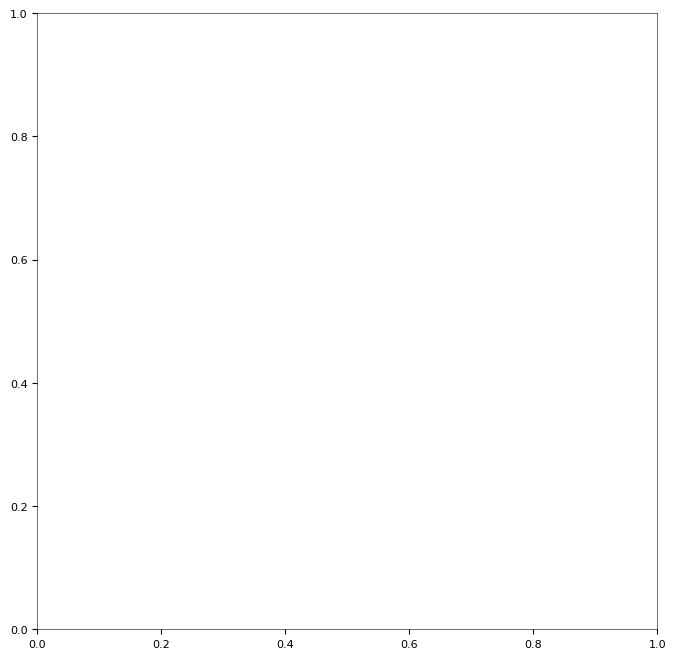

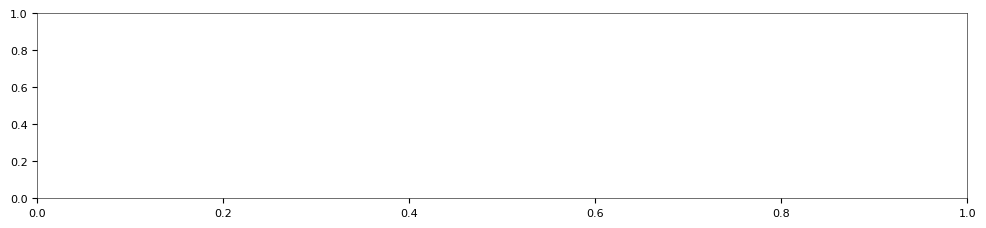

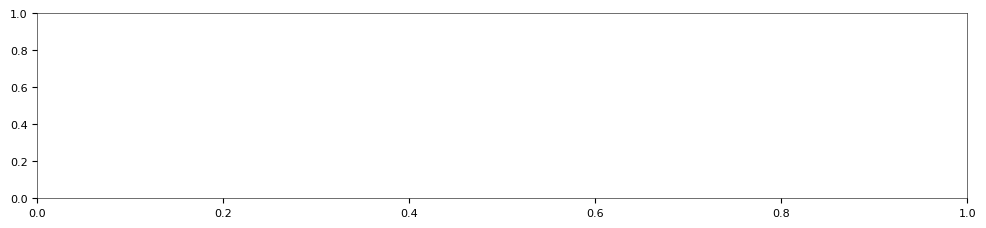

In [10]:
# Building a clean table of the best model's layers
def summarize_layers(model):
    rows = []
    for lyr in model.layers:
        row = {
            "name": lyr.name,
            "type": lyr.__class__.__name__,
            "output_shape": getattr(lyr, "output_shape", None),
            "activation": getattr(lyr, "activation", None).__name__ if hasattr(lyr, "activation") and lyr.activation else None,
            "units/filters": getattr(lyr, "units", getattr(lyr, "filters", None)),
            "kernel_size": getattr(lyr, "kernel_size", None),
            "pool_size": getattr(lyr, "pool_size", None),
            "rate": getattr(lyr, "rate", None),
        }
        rows.append(row)
    return pd.DataFrame(rows)

best_table = summarize_layers(best["model"])
best_table

In [9]:
# diagram of the best model
keras.utils.plot_model(best["model"], to_file="figs_q2c/q2c_best_model.png",
                       show_shapes=True, dpi=140)
print("Saved: figs_q2c/q2c_heatmap.png, figs_q2c/q2c_bar_sorted.png, figs_q2c/q2c_results.csv, figs_q2c/q2c_best_model.png")

Saved: figs_q2c/q2c_heatmap.png, figs_q2c/q2c_bar_sorted.png, figs_q2c/q2c_results.csv, figs_q2c/q2c_best_model.png
